# EDA Obligatorio: Exploración del Corpus de Documentos

Este cuaderno realiza un análisis exploratorio de datos sobre el corpus de documentos para la comparación de RAG.

**Objetivos**:
1. Inventariar todos los documentos en `data/raw/`
2. Analizar estadísticas de archivos (tamaño, formato, distribución)
3. Verificar la calidad de los datos (codificación, legibilidad)
4. Evaluar la compatibilidad con GFS (límites de tamaño de archivo, formatos soportados)
5. Estimar costos de procesamiento

In [1]:
%matplotlib inline

import sys
from pathlib import Path

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import scan_documents, check_gfs_compatibility, compute_file_hash
from utils import format_bytes

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("Imports successful")

Imports successful


## 1. Inventario y Estadísticas de Archivos

In [2]:
# Scan documents
data_dir = project_root / "data" / "raw"
df = scan_documents(data_dir)

print(f"Total files found: {len(df)}")
print(f"\nDataFrame schema:")
print(df.schema)
print(f"\nFirst 5 files:")
df.head()

Total files found: 4

DataFrame schema:
Schema({'file_path': String, 'file_name': String, 'extension': String, 'size_bytes': Int64, 'size_mb': Float64, 'modified_time': Float64})

First 5 files:


file_path,file_name,extension,size_bytes,size_mb,modified_time
str,str,str,i64,f64,f64
"""/Users/ggoni/docencia-repos/ra…","""data_science_workflow.txt""",""".txt""",9155,0.01,1.7645e9
"""/Users/ggoni/docencia-repos/ra…","""nlp_overview.txt""",""".txt""",6836,0.01,1.7645e9
"""/Users/ggoni/docencia-repos/ra…","""deep_learning_guide.txt""",""".txt""",5367,0.01,1.7645e9
"""/Users/ggoni/docencia-repos/ra…","""ml_fundamentals.txt""",""".txt""",3324,0.0,1.7645e9


In [3]:
# Summary statistics
if len(df) > 0:
    print("File Statistics:")
    print(f"Total size: {format_bytes(df['size_bytes'].sum())}")
    print(f"\nSize distribution:")
    print(df.select([
        pl.col("size_mb").min().alias("min_mb"),
        pl.col("size_mb").median().alias("median_mb"),
        pl.col("size_mb").mean().alias("mean_mb"),
        pl.col("size_mb").max().alias("max_mb"),
    ]))
else:
    print("No files found in data/raw/")
    print("Add your documents to continue exploration.")

File Statistics:
Total size: 24.10 KB

Size distribution:
shape: (1, 4)
┌────────┬───────────┬─────────┬────────┐
│ min_mb ┆ median_mb ┆ mean_mb ┆ max_mb │
│ ---    ┆ ---       ┆ ---     ┆ ---    │
│ f64    ┆ f64       ┆ f64     ┆ f64    │
╞════════╪═══════════╪═════════╪════════╡
│ 0.0    ┆ 0.01      ┆ 0.0075  ┆ 0.01   │
└────────┴───────────┴─────────┴────────┘


In [4]:
# File type distribution
if len(df) > 0:
    file_types = df.group_by("extension").agg([
        pl.count().alias("count"),
        pl.col("size_mb").sum().alias("total_size_mb")
    ]).sort("count", descending=True)
    
    print("\nFile types:")
    print(file_types)


File types:
shape: (1, 3)
┌───────────┬───────┬───────────────┐
│ extension ┆ count ┆ total_size_mb │
│ ---       ┆ ---   ┆ ---           │
│ str       ┆ u32   ┆ f64           │
╞═══════════╪═══════╪═══════════════╡
│ .txt      ┆ 4     ┆ 0.03          │
└───────────┴───────┴───────────────┘


/var/folders/p1/vpgfln0n1_z645h_60n7_9940000gr/T/ipykernel_83561/187474375.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


## 2. Visualizaciones

/var/folders/p1/vpgfln0n1_z645h_60n7_9940000gr/T/ipykernel_83561/1611415062.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("count"),


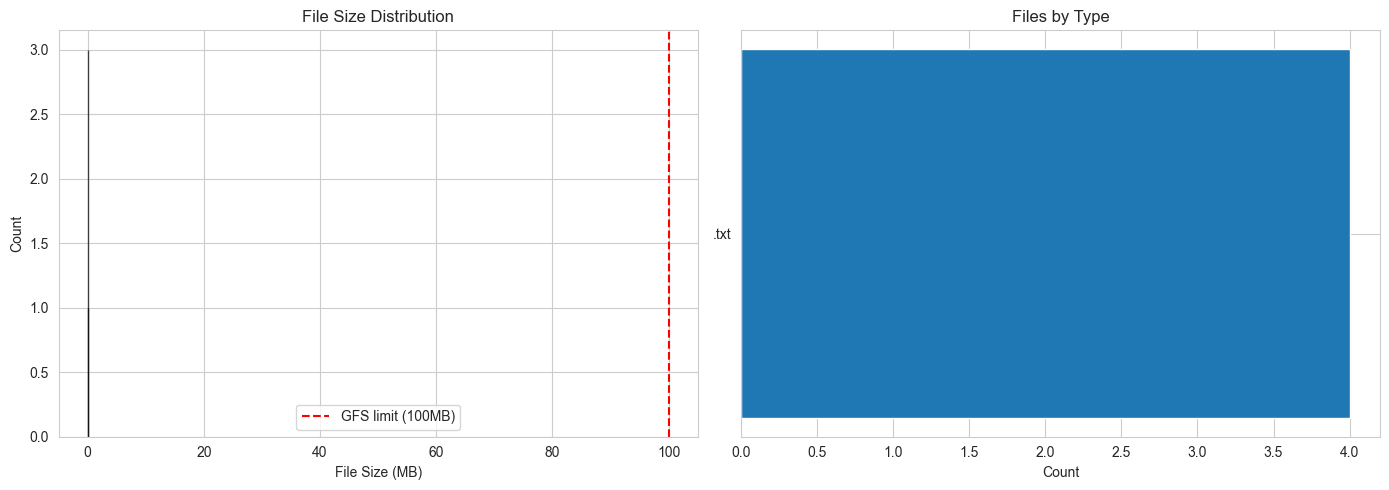

In [5]:
# Size distribution histogram
if len(df) > 0:
    # Recalculate file types for this cell
    file_types = df.group_by("extension").agg([
        pl.count().alias("count"),
        pl.col("size_mb").sum().alias("total_size_mb")
    ]).sort("count", descending=True)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # File size histogram
    df_pd = df.to_pandas()
    ax1.hist(df_pd["size_mb"], bins=30, edgecolor="black", alpha=0.7)
    ax1.axvline(100, color="red", linestyle="--", label="GFS limit (100MB)")
    ax1.set_xlabel("File Size (MB)")
    ax1.set_ylabel("Count")
    ax1.set_title("File Size Distribution")
    ax1.legend()
    
    # File type counts
    file_types_pd = file_types.to_pandas()
    ax2.barh(file_types_pd["extension"], file_types_pd["count"])
    ax2.set_xlabel("Count")
    ax2.set_title("Files by Type")
    
    plt.tight_layout()
    plt.show()

## 3. Verificación de Compatibilidad con GFS

In [6]:
# Check GFS compatibility
if len(df) > 0:
    df_compat = check_gfs_compatibility(df)
    
    compatible_count = df_compat.filter(pl.col("gfs_compatible")).height
    incompatible_count = len(df_compat) - compatible_count
    
    print(f"GFS Compatibility:")
    print(f"  Compatible: {compatible_count}")
    print(f"  Incompatible: {incompatible_count}")
    
    if incompatible_count > 0:
        print("\nIncompatible files:")
        print(df_compat.filter(~pl.col("gfs_compatible")).select([
            "file_name", "extension", "size_mb", "gfs_compatible"
        ]))

GFS Compatibility:
  Compatible: 4
  Incompatible: 0


## 4. Verificaciones de Calidad de Datos

In [7]:
# Sample content inspection (for text files)
if len(df) > 0:
    text_files = df.filter(pl.col("extension").is_in([".txt", ".md"]))
    
    if len(text_files) > 0:
        print("Sample text file content:")
        sample_file = Path(text_files[0, "file_path"])
        print(f"\nFile: {sample_file.name}")
        print("=" * 60)
        
        try:
            with open(sample_file, "r", encoding="utf-8") as f:
                content = f.read(500)  # First 500 chars
            print(content)
            print("\n[truncated...]")
        except Exception as e:
            print(f"Error reading file: {e}")

Sample text file content:

File: data_science_workflow.txt
Data Science Workflow: A Practical Guide

Introduction
Data science is an interdisciplinary field that uses scientific methods, algorithms, and systems to extract knowledge and insights from structured and unstructured data. A systematic workflow ensures reproducibility, efficiency, and high-quality results.

The Data Science Lifecycle

1. Problem Definition
Critical first step that shapes the entire project:
- Understand business objectives and constraints
- Define success metrics and KPIs
- Id

[truncated...]


## 5. Estimación de Costos

In [8]:
# Estimate GFS indexing cost
# Assuming ~1 token per 4 characters for estimation
if len(df) > 0:
    total_mb = df["size_mb"].sum()
    total_bytes = df["size_bytes"].sum()
    
    # Rough token estimation (text files)
    # Assumes average 1KB = ~250 tokens
    estimated_tokens = (total_bytes / 1024) * 250
    
    # GFS pricing: $0.15 per 1M tokens for indexing
    indexing_cost = (estimated_tokens / 1_000_000) * 0.15
    
    print("Cost Estimation (rough):")
    print(f"  Total data size: {total_mb:.2f} MB")
    print(f"  Estimated tokens: {estimated_tokens:,.0f}")
    print(f"  Estimated GFS indexing cost: ${indexing_cost:.4f}")
    print("\nNote: This is a rough estimate. Actual cost depends on file content.")

Cost Estimation (rough):
  Total data size: 0.03 MB
  Estimated tokens: 6,026
  Estimated GFS indexing cost: $0.0009

Note: This is a rough estimate. Actual cost depends on file content.


## Resumen

Este EDA proporciona:
- Inventario y estadísticas de archivos
- Evaluación de compatibilidad con GFS
- Verificaciones de calidad de datos
- Proyecciones de costos

**Próximos Pasos**:
1. Agregar documentos a `data/raw/` si está vacío
2. Proceder a `02_gfs_setup.ipynb` para crear el almacén de búsqueda de archivos
3. Implementar la línea base de RAG personalizado para comparación